# E-commerce — Анализ товарного ассортимента

### Материалы
[Дашборд](https://public.tableau.com/views/Dashboard_automatization/Dashboard?:language=en&:display_count=y&publish=yes&:origin=viz_share_link)

Настоящий проект направлен на оптимизацию товарного ассортимента интернет-магазина товаров для дома и быта, поиск инсайтов и определение рекомендаций по работе с клиентами. 

#### Оглавление: 
<a class="anchor" id="step_0"></a>  

* [1. Получение и загрузка данных;](#step_1)
* [2. Подготовка данных;](#step_2)
* [3. EDA](#step_3)
 * [3.1. Состав категорий товаров;](#step_3.1)
 * [3.2. Топ 10 товаров продаж по кол-ву и Топ 10 самых дорогих товаров;](#step_3.2)
 * [3.3. Накопительные продажи по дням в разрезе категорий в денежном выражении](#step_3.3)
 * [3.4. Распределение величин в категориях товаров](#step_3.4)
 * [3.5. Распределение величин в ценовых категориях](#step_3.5)
 * [3.6. Сезонность продаж по категориям;](#step_3.6)
 * [3.7. Разделение ассортимента на основной и дополнительный;](#step_3.7)
* [4. Проверка гипотез](#step_4) 
 * [4.1. Количество товара в заказах одинаково;](#step_4.1)
 * [4.2. Сумма заказов во всех группах одинакова;](#step_4.2)
* [5. Выводы и рекомендации](#step_5)

In [1]:
import pandas as pd # Импортируем необходимые библиотеки
import numpy as np
import datetime as dt
from scipy import stats as st
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from pymystem3 import Mystem
from collections import Counter
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, 
                             roc_curve, auc, silhouette_score)




# sns.set()
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
gbs = '\033[32m' # переменная для цвета в коде начало
gbe = '\033[0m'  # переменная для цвета в коде конец

In [2]:
# # Извлекаем hex коды цветовой палитры
# palette = 'Accent'
# pal = sns.color_palette(palette)
# pal.as_hex()

## 1. Получение и загрузка данных
[к оглавлению](#step_0)
<a class="anchor" id="step_1"></a>

In [3]:
# Загрузим датасеты
try:
    df = pd.read_csv('/Users/victor/Documents/GitHub/final/ecommerce_dataset.csv')   
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')

In [4]:
display(df.head(3))
display(df.info())

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

На первый взгляд датасет не большой. Пропусков нет. Вызывает вопрос целочисленный тип данных "Дата".  
Решением этой и многих других проблем займемся в разделе подготовки данных.

## 2. Подготовка данных
[к оглавлению](#step_0)
<a class="anchor" id="step_2"></a>

Приступим с приведения в соответствие типа данных "Дата". 

In [5]:
df['date'].unique()

array([2018100100, 2018100108, 2018100109, ..., 2019103113, 2019103114,
       2019103116])

Целое число скорее всего это __год-месяц-день-час__ Исправим формат и проверим результат.

In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [7]:
display(df.head(3))
display(df.info())

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6737 non-null   datetime64[ns]
 1   customer_id  6737 non-null   object        
 2   order_id     6737 non-null   int64         
 3   product      6737 non-null   object        
 4   quantity     6737 non-null   int64         
 5   price        6737 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.9+ KB


None

Проверим за какой период у нас данные и добавим столбцы с выделенным месяцем, часом и днем недели.

In [8]:
display(df['date'].describe())
start = df['date'].describe()['first']
finish = df['date'].describe()['last']
period = finish - start
print(f'Начало наблюдений {gbs}{start}{gbe} конец {gbs}{finish}{gbe} период {gbs}{period}{gbe}')

count                    6737
unique                   2606
top       2019-04-27 16:00:00
freq                       51
first     2018-10-01 00:00:00
last      2019-10-31 16:00:00
Name: date, dtype: object

Начало наблюдений 2018-10-01 00:00:00 конец 2019-10-31 16:00:00 период 395 days 16:00:00


In [9]:
df['month'] = df['date'].astype('datetime64[M]')
df['week_day'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.round("D")
df.head(3)

,date,customer_id,order_id,product,quantity,price,month,week_day,hour,day
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00,2018-10-01,0,0,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00,2018-10-01,0,0,2018-10-01
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00,2018-10-01,0,0,2018-10-01


Проверим данные на полные дубликаты.

In [10]:
df['product'] = df['product'].apply(lambda x: x.lower())

In [11]:
print(f'В датафрейме выявлено {gbs}{df.duplicated().sum()}{gbe} полных дубликатов')

В датафрейме выявлено 0 полных дубликатов


Предположим что данные по заказам могут задваиваться. Назовем задвоением полностью идентичный заказ с разницей в дате и id клиента<a class="anchor" id="step_10"></a>  

In [12]:
df['dupl'] = df.duplicated(subset=['order_id', 'product', 'quantity'], keep = False)
df.dupl.sum()
print(f'В датафрейме выявлено {gbs}{df.dupl.sum()}{gbe} неявных дубликатов из {gbs}{df.dupl.count()}{gbe} записей \
это {gbs}{(df.dupl.sum() / df.dupl.count()):.2%}{gbe}')

В датафрейме выявлено 2426 неявных дубликатов из 6737 записей это 36.01%


С неявными дубликатами дела обстоят похуже. Проверим содержание таких заказов.

In [13]:
duplicatos = df.query('dupl == True').groupby(['order_id']).agg({'customer_id':'nunique',
                                                                 'date':['nunique','first', 'last']})
duplicatos.columns = ['customers', 'times', 'first_time', 'last_time']
duplicatos
duplicatos['delta'] = (
    (duplicatos['last_time'] - duplicatos['first_time']) / np.timedelta64(1, 'h')).round().astype('int')
display(df.query('dupl == True & order_id == 14504'))
display(duplicatos.sort_values(by='times', ascending=False).head(5))
display(duplicatos.delta.describe().to_frame().T)

,date,customer_id,order_id,product,quantity,price,month,week_day,hour,day,dupl
650,2018-11-05 22:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни душицы в горшке диам....,1,101.00,2018-11-01,0,22,2018-11-06,True
651,2018-11-05 22:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни мелиссы в горшке диам...,1,101.00,2018-11-01,0,22,2018-11-06,True
652,2018-11-05 22:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни розмарина в горшке ди...,1,101.00,2018-11-01,0,22,2018-11-06,True
653,2018-11-05 22:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни тимьяна в горшке диам...,1,101.00,2018-11-01,0,22,2018-11-06,True
656,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни душицы в горшке диам....,1,101.00,2018-11-01,1,7,2018-11-06,True
657,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни мелиссы в горшке диам...,1,101.00,2018-11-01,1,7,2018-11-06,True
658,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни розмарина в горшке ди...,1,101.00,2018-11-01,1,7,2018-11-06,True
659,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни тимьяна в горшке диам...,1,101.00,2018-11-01,1,7,2018-11-06,True


,customers,times,first_time,last_time,delta
order_id,,,,,
14833,1,73,2019-05-31 12:00:00,2019-06-22 06:00:00,522
70960,1,60,2019-04-01 16:00:00,2019-10-28 10:00:00,5034
69162,1,23,2018-12-01 12:00:00,2018-12-30 17:00:00,701
71148,1,16,2019-04-15 12:00:00,2019-06-05 20:00:00,1232
69531,2,12,2018-12-23 14:00:00,2019-03-06 14:00:00,1752


,count,mean,std,min,25%,50%,75%,max
delta,276.00,132.75,424.16,0.00,4.00,18.00,60.50,5034.00


На примере заказа __14504__ видим что в заказе 4 позиции. В первый раз заказ фиксируется 5 ноября, во второй раз 6 ноября. И таких заказов 276. Количество дублей доходит до 73 временной разрыв между первой и последней фиксацией до 5034 часов.  

Похоже данные выгружаются некорректно и в продажи попали просмотры корзины или какое-то иное действие связанное с заказом но не фактом оплаты. За разъяснениями обратимся к дата-инженерам, а пока удалим все дубликаты, оставив последнюю запись.

In [14]:
df.drop_duplicates(subset=['order_id', 'product', 'quantity'], keep='last', inplace = True)

In [15]:
df = df.drop('dupl', axis=1).copy()

In [16]:
df.query('order_id == 14504')

,date,customer_id,order_id,product,quantity,price,month,week_day,hour,day
656,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни душицы в горшке диам....,1,101.00,2018-11-01,1,7,2018-11-06
657,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни мелиссы в горшке диам...,1,101.00,2018-11-01,1,7,2018-11-06
658,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни розмарина в горшке ди...,1,101.00,2018-11-01,1,7,2018-11-06
659,2018-11-06 07:00:00,9e2710d8-2a24-4dd2-86a5-bd5e4c5ebea8,14504,рассада зелени для кухни тимьяна в горшке диам...,1,101.00,2018-11-01,1,7,2018-11-06


In [17]:
df.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1')

,customer_id
order_id,
69485,2


In [18]:
df.query('order_id == 69485')

,date,customer_id,order_id,product,quantity,price,month,week_day,hour,day
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,набор столовых приборов 24 предмета saint germ...,1,1087.00,2018-12-01,3,16,2018-12-21
1384,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,набор столовых приборов 24 предмета farandole ...,1,1274.00,2018-12-01,2,23,2018-12-27


In [19]:
df = df.query('order_id != 69485').copy()

Для категоризации товаров поступим следующим образом:  
>- получим лемматизарованную форму названия товара
>- выберем первые два слова (этого будет достаточно что бы понять о чем речь)
>- сгруппируем пары слов по уникальным значениям
>- выгрузим полученный датафрейм в гугл докс
>- в гугл докс фильтрами проставим все категории (все странные слова это декоративные растения, остальное по логике)
>- вернем долученный справочник обратно в проект и проставим категории товаров в рабочем датафрейме

In [20]:
df['product'].unique()[:10]

array(['комнатное растение в горшке алое вера, d12, h30',
       'комнатное растение в горшке кофе арабика, d12, h25',
       'радермахера d-12 см h-20 см', 'хризолидокарпус лутесценс d-9 см',
       'циперус зумула d-12 см h-25 см', 'шеффлера лузеана d-9 см',
       'юкка нитчатая d-12 см h-25-35 см',
       'настенная сушилка для белья gimi brio super 100',
       'таз пластмассовый 21,0 л круглый "водолей" с614, 1404056',
       'чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379'],
      dtype=object)

In [21]:
m = Mystem()

In [22]:
word_list = []
for i in df['product']:
    words = ''.join(m.lemmatize(i.lower())).strip().split()
    word_list.append(' '.join(words[:2]))
key_words = set(word_list)

In [23]:
key_words = pd.DataFrame(data=key_words)
key_words.columns = ['key_word']
key_words = key_words.sort_values(by='key_word').reset_index(drop=True)
#key_words.to_csv('category.csv')
key_words.head()

,key_word
0,tepмокружка avex
1,автоматический щетка
2,агератум рассада
3,адиантум лиза
4,азалия индик


In [24]:
spreadsheet_id = "13Efw07_lvt0dyHSROJrr_Lgpm-3cSfSiGnSYdqmDca0"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
categories = pd.read_csv(BytesIO(r.content), index_col=0)
categories.head()

,key_word,category
0,tepмокружка avex,товары для кухни
1,автоматический щетка,хозтовары
2,агератум рассада,растения
3,адиантум лиза,растения
4,азалия индик,растения


In [25]:
df['key_word'] = word_list
df = pd.merge(df, categories, on='key_word')
df = df.drop('key_word', axis=1).copy()
df['revenue'] = df['quantity'] * df['price']
df.head(3)

,date,customer_id,order_id,product,quantity,price,month,week_day,hour,day,category,revenue
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,2018-10-01,0,0,2018-10-01,растения,142.00
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.00,2018-10-01,0,0,2018-10-01,растения,194.00
2,2018-10-04 09:00:00,e64aad3a-fffc-4193-8df5-e94a43eff295,68521,"комнатное растение в горшке кофе арабика, d12,...",1,194.00,2018-10-01,3,9,2018-10-04,растения,194.00


**Вывод**  
На первом этапе мы скорректировали формат даты, выяснили что данные собраны за 11 месяцев, избавились от дублей, добавили категории товарам и временные категории. Двигаемся дальше.

Проверим как распределились наши категории и выведем информацию сколько товаров входит в каждую из групп.

In [26]:
df.query('category != category')

,date,customer_id,order_id,product,quantity,price,month,week_day,hour,day,category,revenue


Как видим, все пустых строчек после присвоения категорий нет

In [27]:
print('В каждую категорию вошло следующее количество товаров')
categories_df = df.groupby('category').agg({'product':'nunique'})
categories_df.loc['Total']= categories_df.sum()
display(categories_df.reset_index())

print(f"До категоризации в датафремейме насчитывалось {df['product'].nunique()} - все распределилось отлично")

В каждую категорию вошло следующее количество товаров


,category,product
0,растения,569
1,сад огород,333
2,товары для дома,360
3,товары для кухни,365
4,хозтовары,712
5,Total,2339


До категоризации в датафремейме насчитывалось 2339 - все распределилось отлично


## 3. EDA
[к оглавлению](#step_0)
<a class="anchor" id="step_3"></a>

### 3.1. Состав категорий товаров
[к оглавлению](#step_0)
<a class="anchor" id="step_3.1"></a>

Сперва проверим структуру продаж. Категорий не так много, для визуализации подойдет круговая диаграмма.

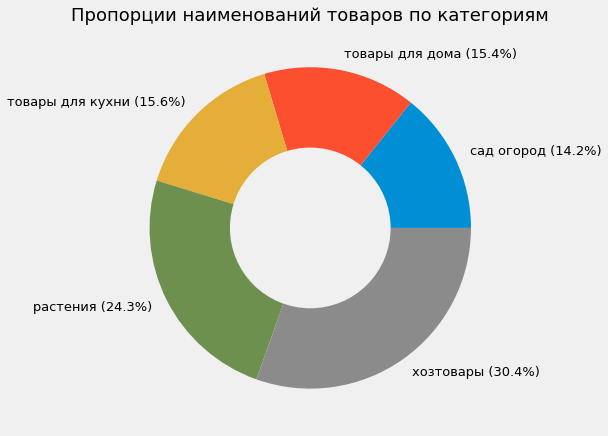

In [28]:
fig, ax = plt.subplots(figsize=[15,6])

# Соберем векторы значений и названий категорий
share_categories = df.groupby('category')['product'].nunique()
data_names = share_categories.sort_values().keys()

# Склеим zip-ом два вектора, чтобы передать в отрисовку лэйбл название +(доля%)
# Итерируем склеенный список двумя переменными, 1 загоняем в название + 2 делим на общий итог и приводим к процентному формату
total = sum(share_categories)
labels = [f"{n} ({v/total:.1%})" for n,v in zip(data_names, share_categories.sort_values())]

plt.pie(x=share_categories.sort_values(), 
        shadow=False,
        labels=labels, pctdistance=0.7, textprops={'fontsize': 13}, startangle = 0)

# Рисуем круг внутри чтоб получился пончик :)))
centre_circle = plt.Circle((0,0),0.50, fc=fig.get_facecolor())
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.title('Пропорции наименований товаров по категориям', fontsize=18)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### 3.2. Топ 10 товаров продаж по количеству и Топ 10 в цене
[к оглавлению](#step_0)
<a class="anchor" id="step_3.2"></a>

Выведем десятку самых продаваемых товаров.

In [29]:
top_10_amount = (df.groupby(['product', 'category']).agg({'quantity':'sum'}).
 sort_values(by='quantity', ascending=False).reset_index().head(10))
display(top_10_amount.style.
        bar(subset=['quantity']).
        set_caption('ТОП 10 товаров по объему продаж').
        hide_index())

product,category,quantity
"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",хозтовары,1000
муляж яблоко 9 см красное,товары для кухни,618
вешалки мягкие для деликатных вещей 3 шт шоколад,товары для дома,335
"ручка-скоба рс-100 белая *трибатрон*, 1108035",хозтовары,200
муляж яблоко зеленый 9 см полиуретан,товары для кухни,188
"крепеж для пружины дверной, 1107055",хозтовары,170
плечики пластмассовые размер 52 - 54 тула 1205158,хозтовары,160
"пружина дверная 240 мм оцинкованная (д-19 мм) без крепления, 1107014",хозтовары,150
муляж банан желтый 21 см полиуретан,товары для кухни,109
"щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096",хозтовары,105


Сразу же обращаем внимание на популярность вантузов. За 11 месяцев продано 1000 шт

In [30]:
top_10_price = (df.groupby(['product', 'category']).agg({'price':'max'}).
 sort_values(by='price', ascending=False).reset_index().head(10))
display(top_10_price.style.
 bar(subset=['price']).
        set_caption('ТОП 10 самых дорогих товаров').
        hide_index())

product,category,price
сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая,хозтовары,14917.000000
"сумка-тележка хозяйственная andersen royal shopper, hera, синяя 166-004-90",хозтовары,8737.000000
"сумка-тележка хозяйственная andersen alu star shopper, hava, синяя 115-103-90",хозтовары,8437.000000
сумка-тележка хозяйственная rolser mnb019 rojo logic dos+2 красная,хозтовары,8077.000000
стремянка 7 ступенчатая hailo 8040-707 xxl 13 см алюминиевая с лотком для инструментов,хозтовары,7724.000000
сумка-тележка хозяйственная rolser mnb017 fucsia logic dos+2 фуксия,хозтовары,7679.000000
сумка-тележка хозяйственная rolser imx006 bassi logic tour бордовая,хозтовары,7679.000000
сумка-тележка хозяйственная rolser mou041 malva rd6 сиреневая,хозтовары,7597.000000
гладильная доска leifheit airboard compact m plus 120х38 см малиновый 71630,товары для дома,7424.000000
урна уличная стальная сальвадор 02.021.0 46х110 см,хозтовары,7349.000000


В десятке самых дорогих товаров лидер - уличная сушилка

### 3.3. Накопительные продажи по дням в разрезе категорий в денежном выражении
[к оглавлению](#step_0)
<a class="anchor" id="step_3.3"></a>

Перед построение накопительных графиков проверим данные на выбросы. Построим визуализации и оценим масштаб бедствия.

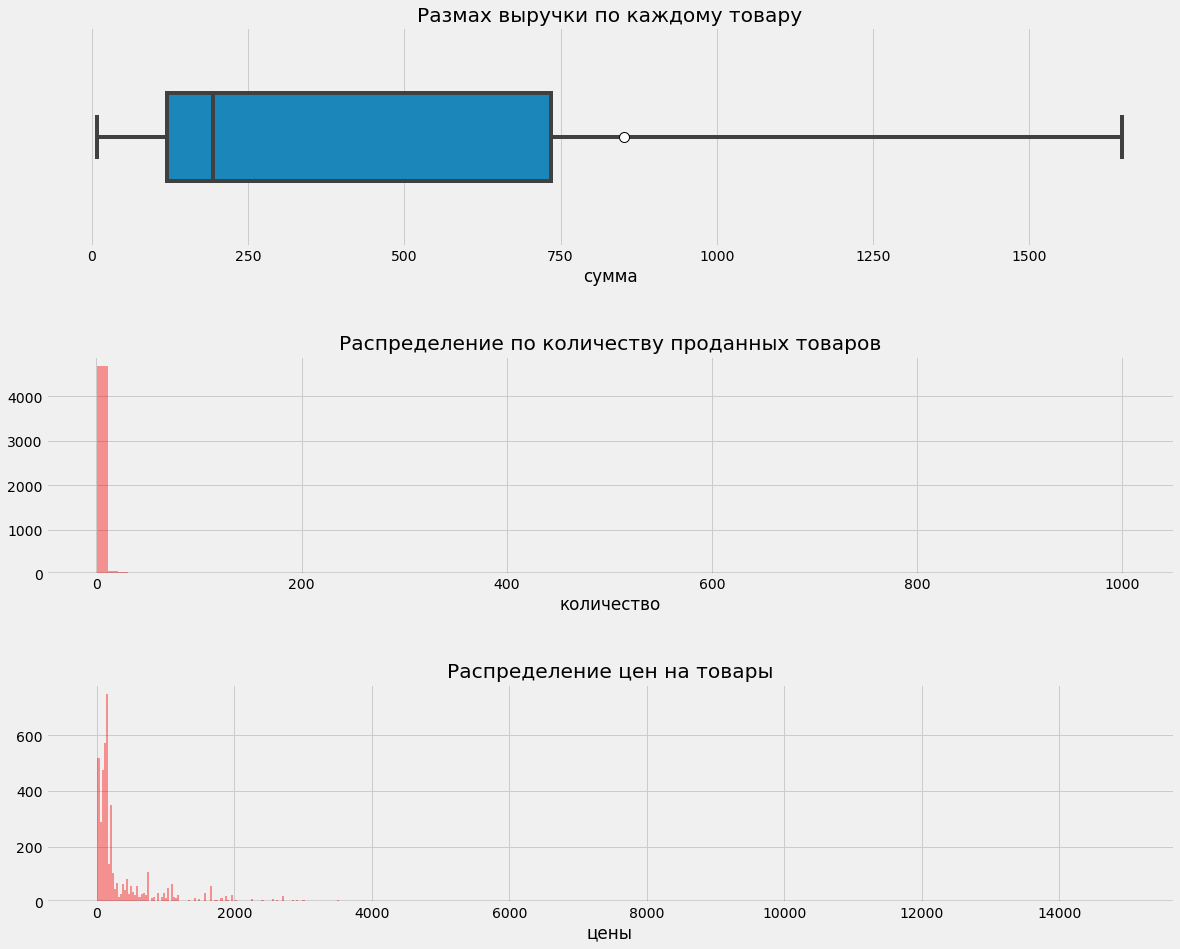

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(18,15))
sns.boxplot(data=df, x='revenue', showfliers=False, showmeans=True, width=0.4,
    meanprops={'marker':'o', 'markerfacecolor':'white', # Добавим белую точку - среднюю для оценки места положения
               'markeredgecolor':'black', # относительно медианы
               'markersize':'10'}, ax = axs[0]).set(title='Размах выручки по каждому товару', ylabel='', xlabel='сумма')
sns.distplot(df['quantity'],kde=False, color='r', bins=100, ax = axs[1]).set(title='Распределение по количеству проданных товаров', ylabel='', xlabel='количество')
axs[1].axhline(y = 0, color = 'black', linewidth = 2.3, alpha = .9)
sns.distplot(df['price'],kde=False, color='r', bins=500, ax = axs[2]).set(title='Распределение цен на товары', ylabel='', xlabel='цены')
axs[2].axhline(y = 0, color = 'black', linewidth = 2.3, alpha = .9)
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

Проанализируем графики:  

>- Очень сильное отдаление средней от медианы на боксплоте с выручкой сигнализирует о серьезных выбросах в сторону увеличения
>- Гистограмма количества проданных товаров так же имеет тяжелый хвост
>- В ценах похожая ситуация


Впрочем такая картина является типичной для продаж. Основная масса - частые единичные продажи и ассортимент состоящий из основной массы и относительно небольшого количества дорогих эксклюзивов.

Выведем статистики для численных показателей

In [32]:
stat = df[['revenue', 'quantity', 'price']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
stat

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
revenue,4835.00,850.89,9845.47,9.00,38.00,120.00,194.00,734.00,2849.00,6148.66,675000.00
quantity,4835.00,2.82,17.65,1.00,1.00,1.00,1.00,1.00,7.00,30.00,1000.00
price,4835.00,514.92,945.78,9.00,37.00,90.00,150.00,488.00,2187.50,4954.28,14917.00


Из всех выбросов ключевым признаем __95 перцентиль по количеству__, т.к. цены устанавливаются не случайно, а исходя из себестоимости и коньюктуры ранка, а выручка это произведение цены на количество.

In [33]:
quantity_outler = stat.loc['quantity']['95%']
quantity_max = stat.loc['quantity']['max']

Определим все сверхвысокие значения количественных продаж как оптовые, оценим их и удалим из датасета, т.к. для последующей проверки статистических гипотез их присутствие скажется не лучшим образом

In [34]:
wholesale = df.query('quantity > @quantity_outler').sort_values(by='revenue', ascending=False)
wholesale = wholesale.groupby(['category']).agg({'customer_id':'count',
                                                 'order_id':'count',
                                                 'quantity':'sum', 
                                                 'revenue':'sum'})
wholesale.loc['Total']= wholesale.sum()

wholesale

,customer_id,order_id,quantity,revenue
category,,,,
растения,29.00,29.00,471.00,52439.00
сад огород,7.00,7.00,66.00,2268.00
товары для дома,69.00,69.00,1425.00,206314.00
товары для кухни,64.00,64.00,1939.00,169308.00
хозтовары,72.00,72.00,3503.00,887341.00
Total,241.00,241.00,7404.00,1317670.00


In [35]:
total_revenue = df['revenue'].sum()
outler_revenue = df.query('quantity > @quantity_outler')['revenue'].sum()
print(f'Суммарные продажи {gbs}{total_revenue}{gbe} выбросные (оптовые) продажи {gbs}{outler_revenue}{gbe} доля\n\
{gbs}{outler_revenue / total_revenue:.2%}{gbe}')

Суммарные продажи 4114033.0 выбросные (оптовые) продажи 1317670.0 доля
32.03%


In [36]:
df_full = df.copy()

In [37]:
df = df.query('quantity < @quantity_outler').copy()

Данные от выбросов очищены. Приступим к построению кумулятивных графиков.  
Т.к. кумулятивных датасетов и графиков мы будем строить много, создадим для этих целей функции, после чего проверим их работоспособность.

In [38]:
def cumulative(df, col_base, col_num, est='sum'):
    '''
    ФУНЦИЯ ДЛЯ СОЗДАНИЯ КУМУЛЯТИВНОГО ДАФРЕЙМА
    на вход подаем
    1) сырой датафрейм, столбец по которуму группируем, столбец измеритель и арифметическое дейтвие. по умолчанию сумма
    2) определяем первую и последнюю даты
    3) внутри формируем вспомогательный датафрейм - календарь
    4) внутри формируем заготовку для кумулятивного датафрейма
    5) пробегаемся по датам и календаря и увеличиваем на агрегированные суммы по группировкам
    '''
    start = df['date'].describe()['first']
    finish = df['date'].describe()['last']
    period = finish - start
    dates = pd.date_range(start=start, periods=(int(str(period).split(' ')[0]) + 1))
    cumulative = pd.DataFrame(columns=df[col_base].unique())
    for i, dt in (enumerate(dates)):
        curent = df.query('date <= @dt').groupby(col_base).agg({col_num: est}).T
        curent['date'] = dt
        cumulative = cumulative.append(curent, sort=False)
    return cumulative.set_index('date').fillna(0).copy()   

In [39]:
cumulative(df,'category', 'quantity', 'sum').tail()

,растения,хозтовары,товары для дома,сад огород,товары для кухни
date,,,,,
2019-10-27,2072,1444,684,1054,779
2019-10-28,2074,1444,686,1054,779
2019-10-29,2080,1446,686,1054,779
2019-10-30,2082,1446,686,1054,780
2019-10-31,2090,1449,691,1054,780


In [40]:
def cumulative_plot(df, title, ylabel, xmin=None, xmax=None):
    '''
    ФУНЦИЯ ДЛЯ ВЫВОДЫ КУМУЛЯТИВНОГО ГРАФИКА
    на вход подаем
    1) кумулятивный датафрейм, название, название оси Y, X - всегда даты, и при необходимости ограничители по датам
    '''
    fig, ax = plt.subplots(figsize=(15,6))
    ax = sns.lineplot(data=df , dashes=False)
    plt.title('Анализ ' + title)
    plt.xlabel('')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1, 1))
    try:
        ax.set_xlim([pd.to_datetime(xmin), pd.to_datetime(xmax)])
    except:
        pass
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.show()

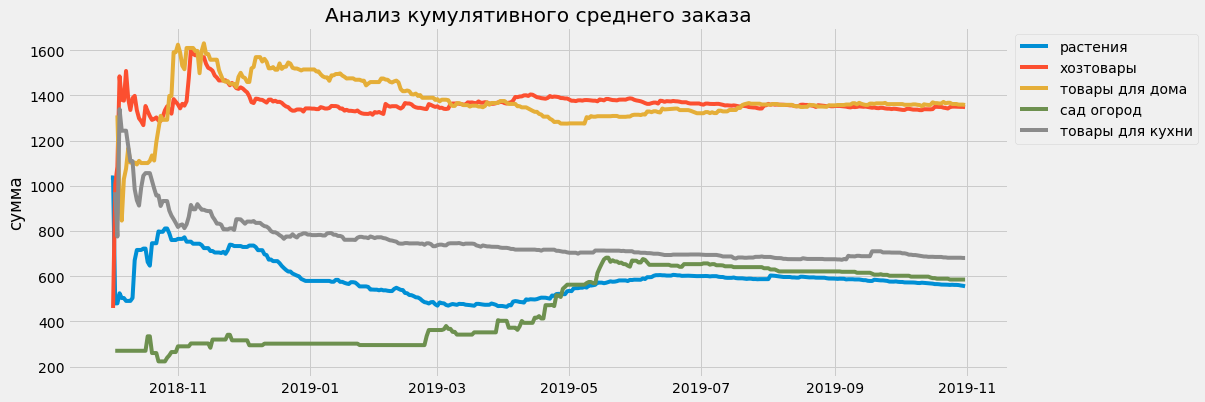

In [41]:
cumulative_plot(
    cumulative(df, 'category', 'revenue')\
    / cumulative(df, 'category', 'order_id', 'nunique'), 'кумулятивного среднего заказа', 'сумма')

Визуализация указывает на шум в начале наблюдений, но потом показатели среднего заказа стабилизируются. Хозтовары и товары для дома оказываются в итоге равны 1400 денег, огородные растения и декоративные так же сравнялись на уровне 600 денег. Немного особнячком расположилась кухня - 700 денег.

У нас сформировалась первая гипотеза. о равенстве средних заказов. Проверим ее дальше.

Выведем кумулятивные графики по выручке и количеству заказов.

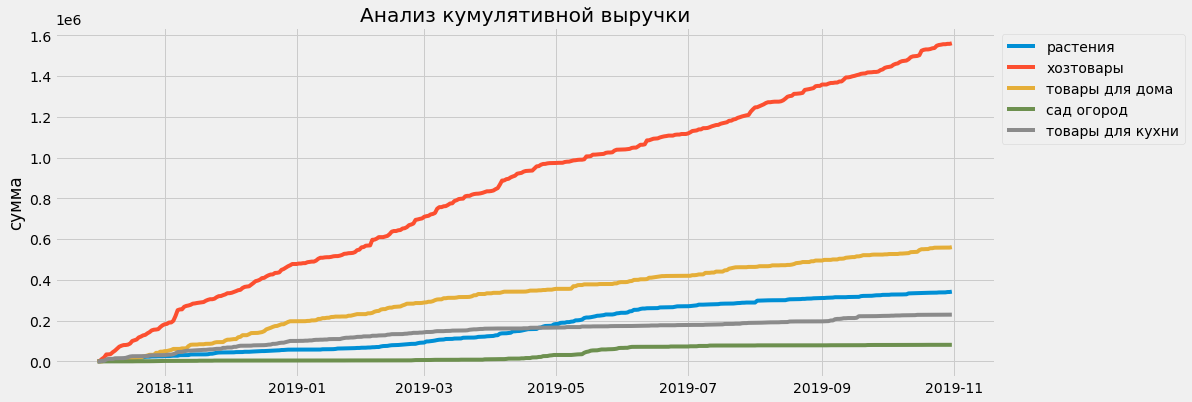

In [42]:
cumulative_plot(cumulative(df,'category', 'revenue'), 'кумулятивной выручки', 'сумма')

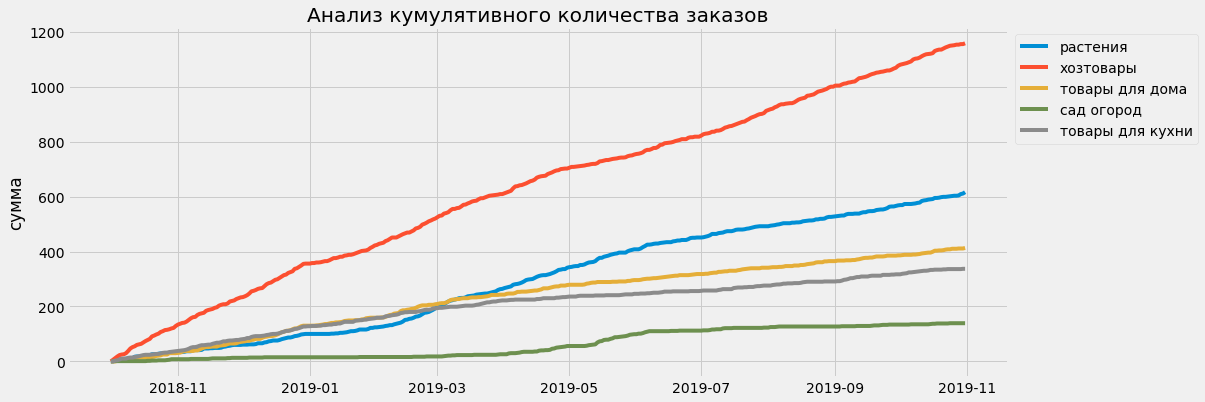

In [43]:
cumulative_plot(cumulative(df,'category', 'order_id', 'nunique'), 'кумулятивного количества заказов', 'сумма')

Графики растут линейно с небольшими колебаниями. Это достигается благодаря избавлению от выбросов.  

* По выручке среди групп фаворитом выступают хозтовары. При высоком среднем заказе и больших продажах эта группа обеспечивает наибольшую выручку. 
* Товары для дома вторые по выручке и третьи в объеме. Второе место так же обеспечивается высокой ценой
* Растения хоть и вторые в объемах продаж вторая про многочисленности группа за счет не высокой цены располагаются на третьем месте
* Товары для кухни на четвертом месте - не самый высокий объем и не самая высокая цена
* По очевидным причинам огородные растения занимают последнее место. Цены не высокие как у декоративных растений, а объемы меньше т.к. товар сезонный

### 3.4. Распределение величин в категориях товаров
[к оглавлению](#step_0)
<a class="anchor" id="step_3.4"></a>

Посмотрим на категории с другой стороны. Построим графики распределения средних величин в разбивке по категориям.  
Для вывода соберем функцию.

In [44]:
def scatter_plot(df, col_group, col_measure, title, ymin=None, ymax=None, est='mean'):
    '''
    ФУНКЦИЯ ДЛЯ ВЫВОДА ГРАФИКА РЕСПРЕДЕЛЕНИЯ ЧЕГО-НИБУДЬ
    На вход подаем:
    1. Сырой датафрейм
    2. Название столбца по которому группируем
    3. Название столбца - измерения на выбор (количество-цена-выручка)
    4. Название графика без слова "Анализ"
    5. Собсвенно измерение на выбор (среднее, количество, сумма) По умолчанию сумма
    '''
    fig, ax = plt.subplots(figsize=(12,5))
    work_df = (df.groupby([col_group, 'category']).
               agg({col_measure:est}).
               reset_index().
               sort_values(by='category').
               reset_index(drop=True))
    sns.scatterplot(data=work_df, x=work_df.index, y=col_measure, hue='category', alpha=0.9, ax=ax)
    cuts = [75, 90, 95, 99]
    percentiles = np.percentile(work_df[col_measure], cuts)
    for i in range(len(percentiles)):
        plt.axhline(y=percentiles[i], color='#5F9EA0', linewidth=1.5, linestyle='--')
        plt.text(x = work_df.shape[0], y=percentiles[i], s=f'{cuts[i]} персентиль', fontsize=10)
    plt.ylim(ymin, ymax)
    plt.title('Анализ ' + title)
    plt.show()

Количество товаров в 1 заказе доходит до 60 позиций. Вспомним что мы удаляли количественные выбросы ранее, но то были данные немного иного характера - количество продаж по товарным позициям, это же количество товаров в 1 заказе.  
75% заказов содержат не более 8 товаров. Самые сгруппированные в этом плане хозтовары и товары для дома. Все растения и кухня показывают больше выбросов за 90 перцентиль. Оставим пока как есть. По при проверке стат гипотез от этих выбросов придется избавиться.

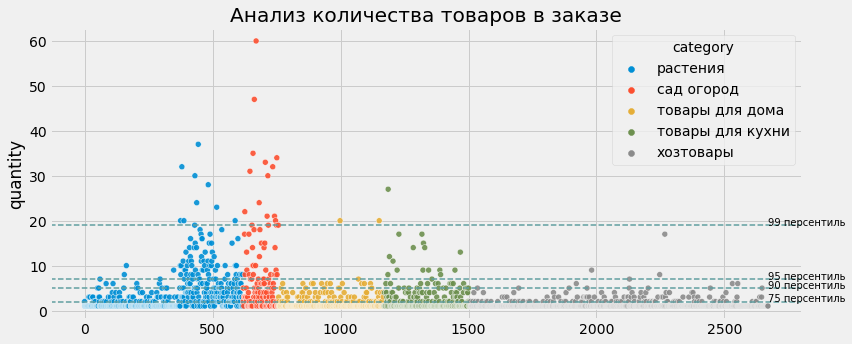

In [45]:
scatter_plot(df, 'order_id', 'quantity', 'количества товаров в заказе', None, None, 'sum')

В стоимости заказов картина иная. Хозтовары и товары для дома более выброшены. Кухня наоборот. Скорее всего это из-за цен

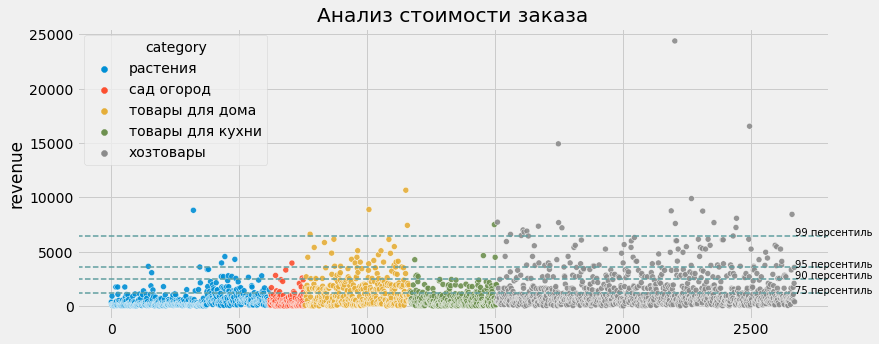

In [46]:
scatter_plot(df, 'order_id', 'revenue', 'стоимости заказа', None, None, 'sum')

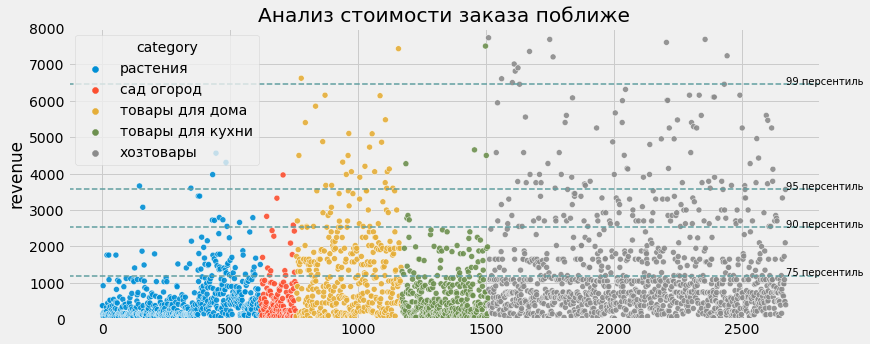

In [47]:
scatter_plot(df, 'order_id', 'revenue', 'стоимости заказа поближе', 0, 8000, 'sum')

Вот и подтверждение. Наибольшее количество дорогих товаров удорожающих средний заказ в хозтоварах и товарах для дома. Растения более однотипны. В кухне промежуточная ситуация.

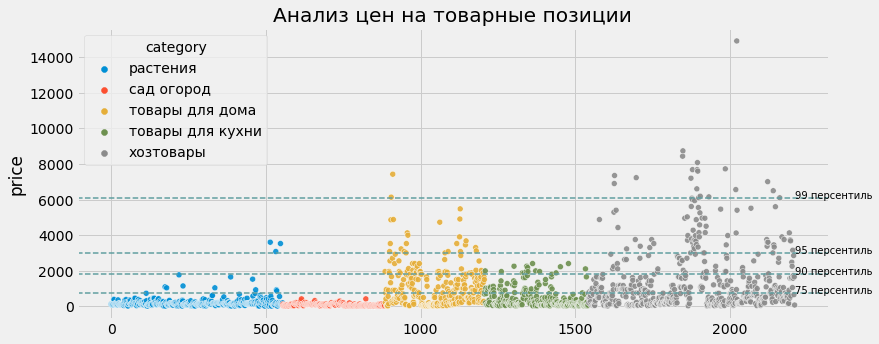

In [48]:
scatter_plot(df, 'product', 'price', 'цен на товарные позиции')

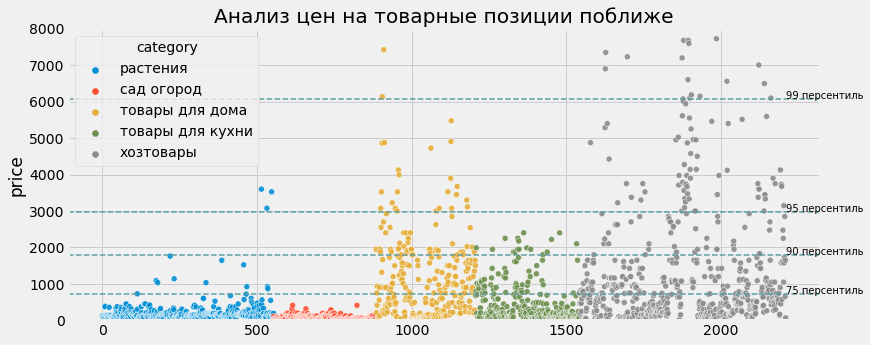

In [49]:
scatter_plot(df, 'product', 'price', 'цен на товарные позиции поближе', 0, 8000)

Напоследок посмотрим сколько заказов создают клиенты. Выбросы свыше 99% можно пересчитать на пальцах, Таких клиентов примерно 10. Кое кто сделал даже 70 заказов в хозтоварах. Это так же выбросы которые нужно учесть при проверке стат гипотез. Приблизим график. Видим что 95% клиентов делают 1-2 заказа, а 99% до 3-ёх

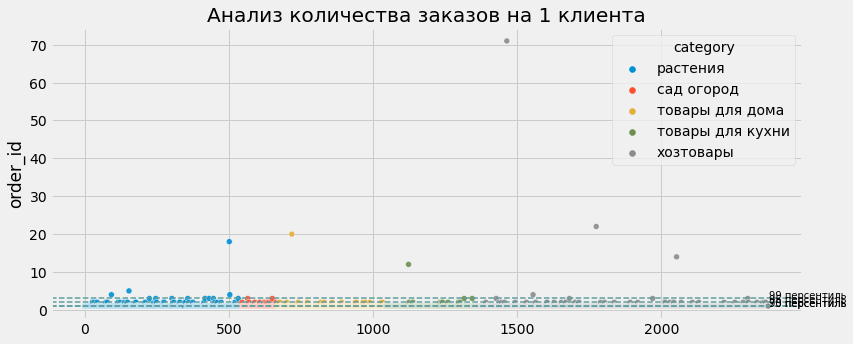

In [50]:
scatter_plot(df, 'customer_id', 'order_id', 'количества заказов на 1 клиента', None, None,'nunique')

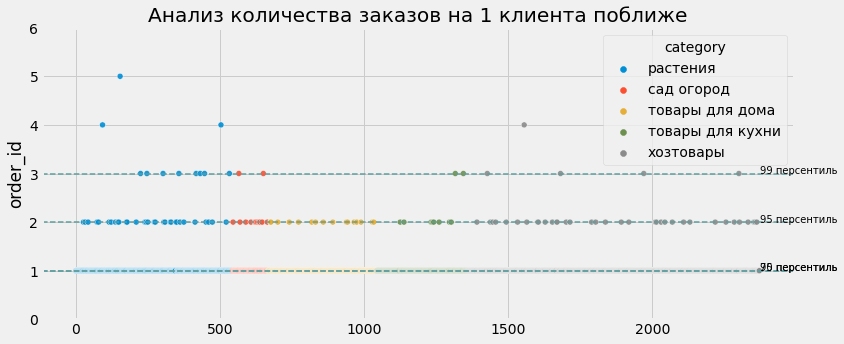

In [51]:
scatter_plot(df, 'customer_id', 'order_id', 'количества заказов на 1 клиента поближе', 0, 6,'nunique')

Оценим найденные выбросы в абсолютных и относительных величинах. Создадим удобную функцию.

In [52]:
def outlerz(df, col_group, col_measure, est='sum', q=95):
    '''
    ФУНЦИЯ ДЛЯ РАБОТЫ С ВЫБРОСАМИ
    на вход подаем
    1) сырой датафрейм, столбец поиска, столбец измеритель и арифметическое дейтвие, 
    (по умолчанию сумма), перцентиль (по умолчанию 95)
    2) считаем перцентиль
    3) выводим сколько выбросы составляют в деньгах
    4) отношение выбросов в деньгих к полной сумме в деньгих
    5) список выброшенных значений столбца поиска
    '''
    work_df = df.groupby(col_group).agg({col_measure:est}).reset_index()
    percentiles = np.percentile(work_df[col_measure], [q])
    weight_items = work_df[work_df[col_measure] > percentiles[-1]][col_group]
    weight_items
    ful_val = df['revenue'].sum()
    outler_val = df[df[col_group].isin(weight_items)]['revenue'].sum()
    return outler_val, outler_val/ful_val, weight_items

Выясним во сколько фирме выходят выбросы в заказах с большим количеством позиций и в клиентах с большим количеством заказов.  
__Зададим 95 перцентиль.__

In [53]:
q = 95

In [54]:
outler_val = outlerz(df, 'order_id', 'quantity', 'sum', q)[0]
relatively = outlerz(df, 'order_id', 'quantity', 'sum', q)[1]
outler_num = len(outlerz(df, 'order_id', 'quantity', 'sum', q)[2])
print(f'Заказов с большим количеством позиций {gbs}{outler_num}{gbe} в деньгах это {gbs}{outler_val:.0f}{gbe}\n\
что составляет {gbs}{relatively:.2%}{gbe} от разничных продаж')

Заказов с большим количеством позиций 123 в деньгах это 236386
что составляет 8.51% от разничных продаж


In [55]:
outler_val = outlerz(df, 'customer_id', 'order_id', 'nunique', q)[0]
relatively = outlerz(df, 'customer_id', 'order_id', 'nunique', q)[1]
outler_num = len(outlerz(df, 'customer_id', 'quantity', 'nunique', q)[2])
print(f'Клиентов с большим количеством заказов {gbs}{outler_num}{gbe} в деньгах это {gbs}{outler_val:.0f}{gbe}\n\
что составляет {gbs}{relatively:.2%}{gbe} от разничных продаж')

Клиентов с большим количеством заказов 38 в деньгах это 267570
что составляет 9.63% от разничных продаж


С выбросами все понятно. Поскольку мы занимаемся не финансовым анализом, где на счету каждая копейка, а статистическим, от этих выбросов впоследствии стоит избавиться.

#### 3.5. Распределение величин в ценовых категориях
[к оглавлению](#step_0)
<a class="anchor" id="step_3.5"></a>

Поскольку цены устанавливаются не случайно, а исходя из коньюктуры ранка с одной стороны и необходимостью приносить прибыль покрывая затраты, с другой стороны, разделим товары по __ценовым категориям__. Для этого создадим матрицу с перцентилями по ценам в каждой группе.

In [56]:
price_vevel = df.groupby('category')['price'].\
describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]).T.iloc[4:-1]
price_vevel

category,растения,сад огород,товары для дома,товары для кухни,хозтовары
5%,74.00,30.00,29.00,22.00,67.00
25%,112.00,38.00,194.00,59.00,374.00
50%,135.00,89.00,712.00,179.00,727.00
75%,164.00,120.00,1649.00,449.50,1199.00
90%,210.00,128.00,2527.00,974.00,2849.00
95%,337.00,191.00,3156.80,1623.10,3974.00
99%,1034.00,285.00,4866.20,2232.80,6856.70


Применим логику, что товары цены которых выше ниже 5% - __эконом__, все что выше - __медиум__. Опишем логику в функции.

In [57]:
def price_category(row):
    for i in price_vevel.columns:
        if row['category'] == i and row['price'] < price_vevel.loc['5%'][i]:
            return i + ' эконом'
        elif row['category'] == i and row['price'] >= price_vevel.loc['5%'][i]:
            return i + ' медиум'

Применим функцию и посмотрим что получилось

In [58]:
df['price_category'] = df.apply(price_category, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4573 entries, 0 to 4834
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4573 non-null   datetime64[ns]
 1   customer_id     4573 non-null   object        
 2   order_id        4573 non-null   int64         
 3   product         4573 non-null   object        
 4   quantity        4573 non-null   int64         
 5   price           4573 non-null   float64       
 6   month           4573 non-null   datetime64[ns]
 7   week_day        4573 non-null   int64         
 8   hour            4573 non-null   int64         
 9   day             4573 non-null   datetime64[ns]
 10  category        4573 non-null   object        
 11  revenue         4573 non-null   float64       
 12  price_category  4573 non-null   object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(4)
memory usage: 500.2+ KB


Для вывода визуализаций распределения величин в ценовых подгруппах каждой товарной категории напишем облегченную функцию __`scatter_plot`__ для работы с циклами

In [59]:
def scatter_plot_lite(df, col_group, col_measure, title, est='sum'):
    work_df = (df.groupby([col_group, 'price_category']).
               agg({col_measure:est}).
               reset_index().
               sort_values(by='price_category').reset_index(drop=True))
    sns.scatterplot(data=work_df, x=work_df.index, y=col_measure, hue='price_category', alpha=0.9)
    cuts = [75, 90, 95]
    percentiles = np.percentile(work_df[col_measure], cuts)
    for i in range(len(percentiles)):
        plt.axhline(y=percentiles[i], color='#5F9EA0', linewidth=1.5, linestyle='--')
        plt.text(x = work_df.shape[0], y=percentiles[i], s=f'{cuts[i]} персентиль', fontsize=10)
    plt.legend().set_visible(False)
    plt.title(title)

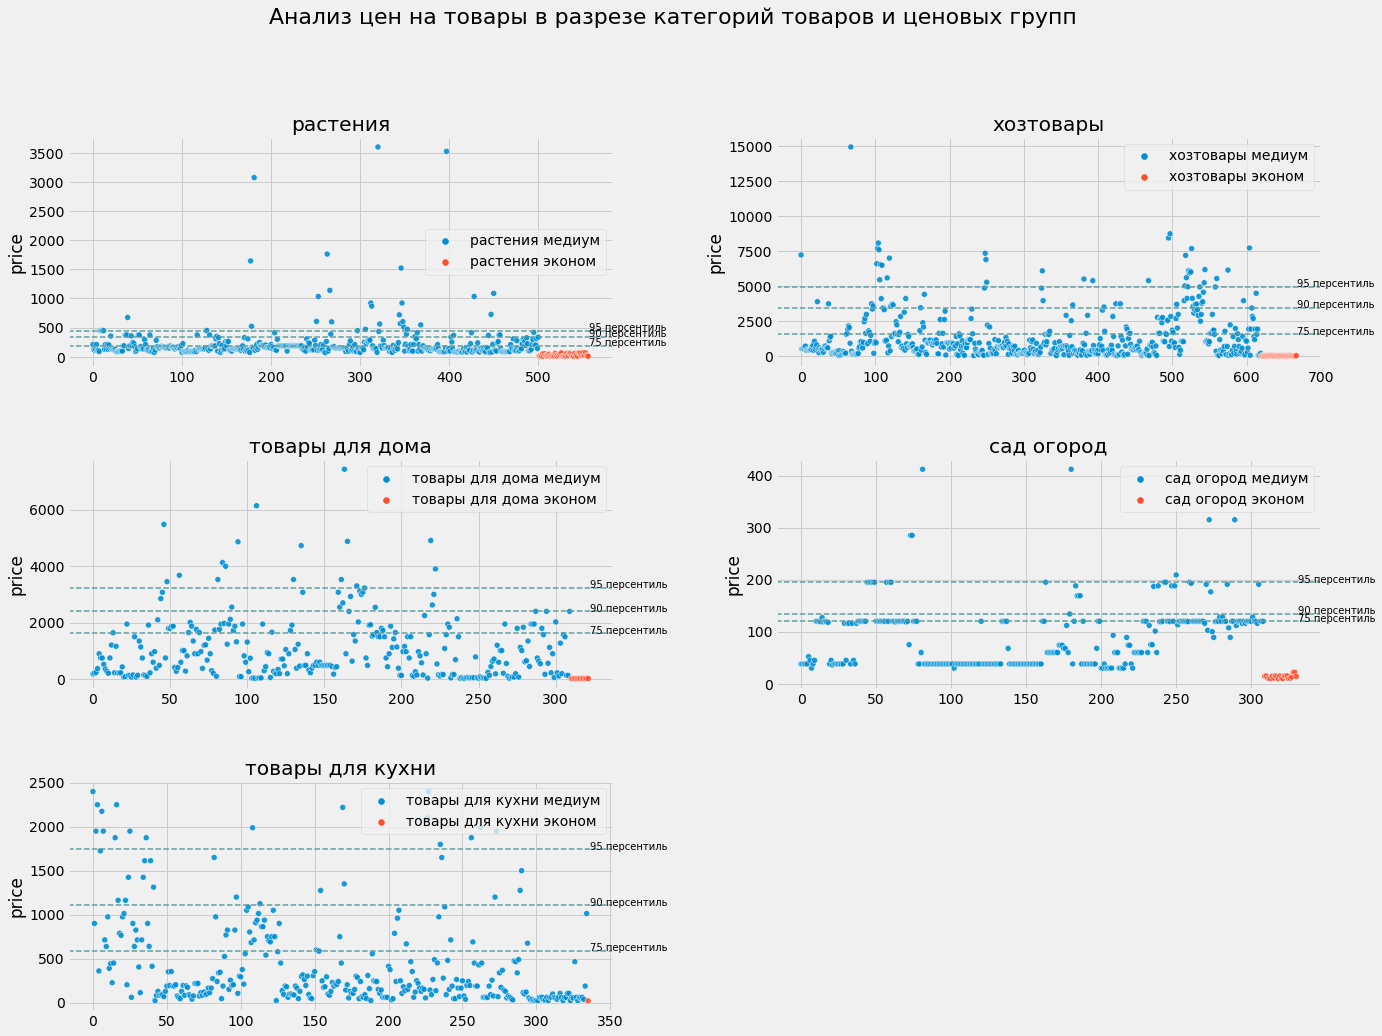

In [60]:
fig = plt.figure(figsize=(20,15))
i = 1
for cat in df['category'].unique():
    fig.add_subplot(3, 2, i)
    scatter_plot_lite(df.query('category == @cat'), 'product', 'price', cat, 'mean')
    plt.legend()
    i += 1
plt.suptitle('Анализ цен на товары в разрезе категорий товаров и ценовых групп', size=22, y=1)
plt.legend()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

Все товары в товарных категориях по ценовым категориям распределены корректно.  
Проанализируем количество продаж в ценовых и товарных категориях

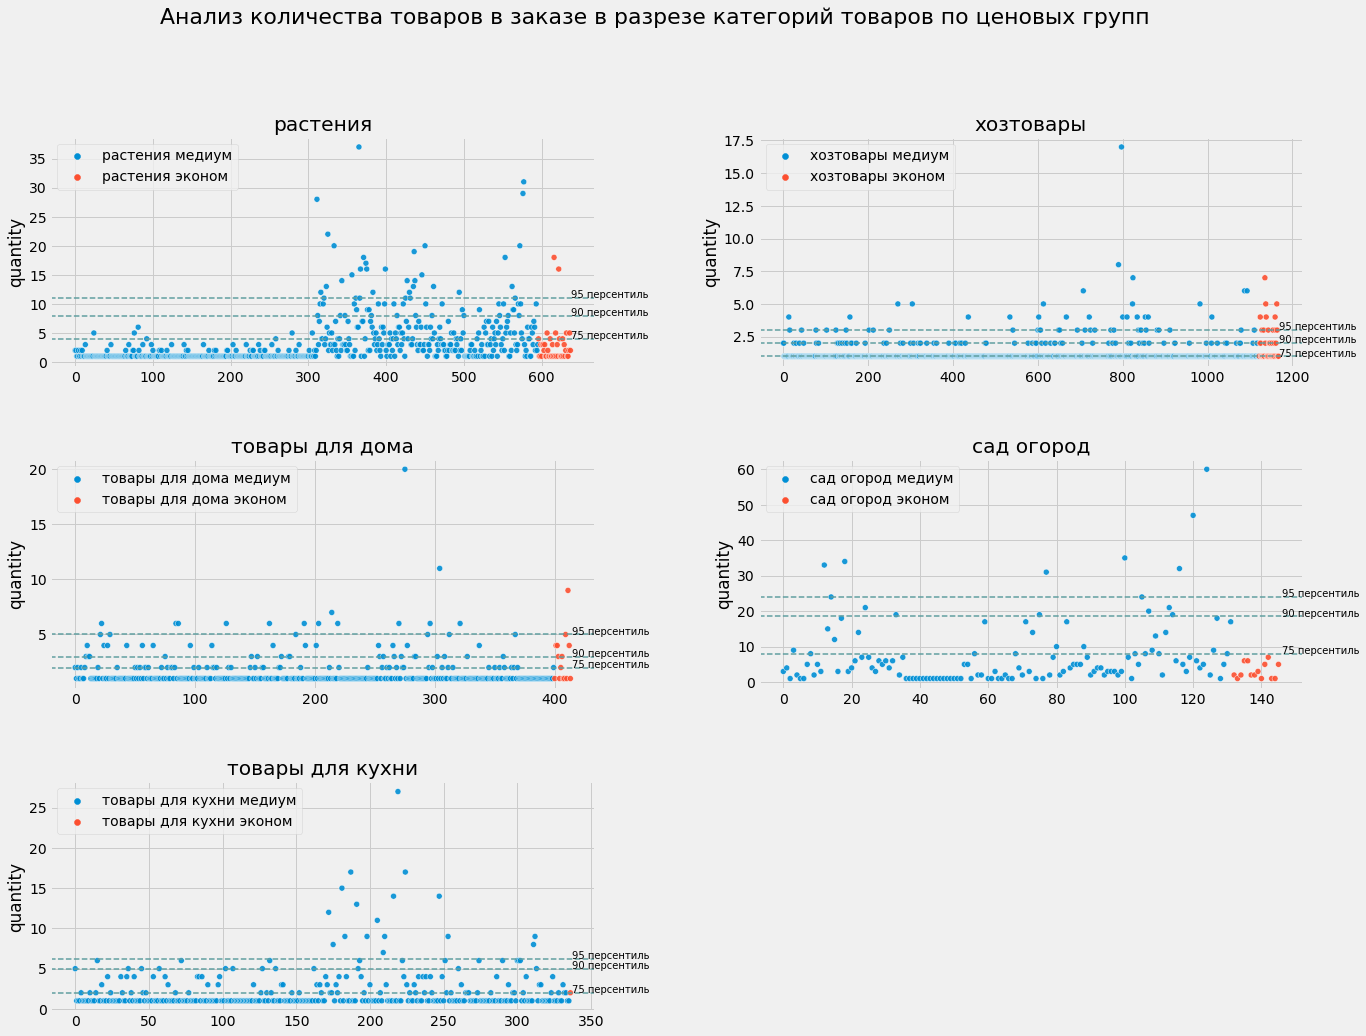

In [61]:
fig = plt.figure(figsize=(20,15))
i = 1
for cat in df['category'].unique():
    fig.add_subplot(3, 2, i)
    scatter_plot_lite(df.query('category == @cat'), 'order_id', 'quantity', cat)
    plt.legend()
    i += 1
plt.suptitle('Анализ количества товаров в заказе в разрезе категорий товаров по ценовых групп', size=22, y=1)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

Во всех товарных категория (а в растениях особенно) клиент склонен выгребать товары со средней ценой больше обычного

### 3.6. Сезонность продаж по категориям
[к оглавлению](#step_0)
<a class="anchor" id="step_3.6"></a>

Для выявления фактора сезонности создадим функцию

In [62]:
'''
ФУНКЦИЯ ДЛЯ ВЫВОДА ГРАФИКА СЕЗОННОСТИ
На вход подаем:
1. Сырой датафрейм
2. Название столбца по которому группируем
3. Название столбца - измерения на выбор (количество-цена-сумма)
4. Название графика без слова "Сезонность продаж"
5. Собсвенно измерение на выбор (среднее, количество, сумма) По умолчанию сумма
'''
def seasons(df, col_base, col_measure, title):
    time_dict ={'month': 'помесячно', 'week_day': 'по дням недели', 'hour': 'в течении суток'}
    for key in time_dict:
        work_df = df.set_index(key)[[col_base, col_measure]].reset_index()
        if key == 'month':
            work_pivot = work_df.pivot_table(
                index=key, columns=col_base, values=col_measure, aggfunc='sum')
        else:
            work_pivot = work_df.pivot_table(
                index=key, columns=col_base, values=col_measure, aggfunc='mean')
        fig, ax = plt.subplots(figsize=(15,6))
        ax = sns.lineplot(data=work_pivot, dashes=False)
        plt.title(f'Сезонность продаж {title} {time_dict[key]}', fontsize=17)
        plt.xlabel('')
        plt.ylabel('')
        plt.show()

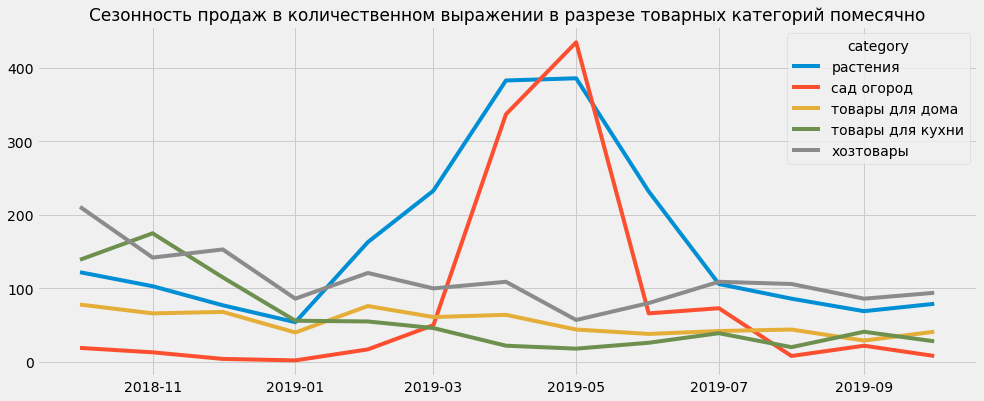

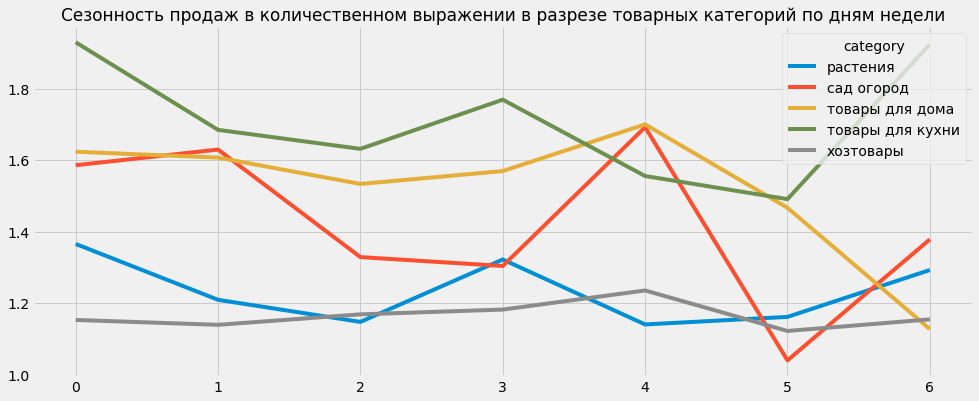

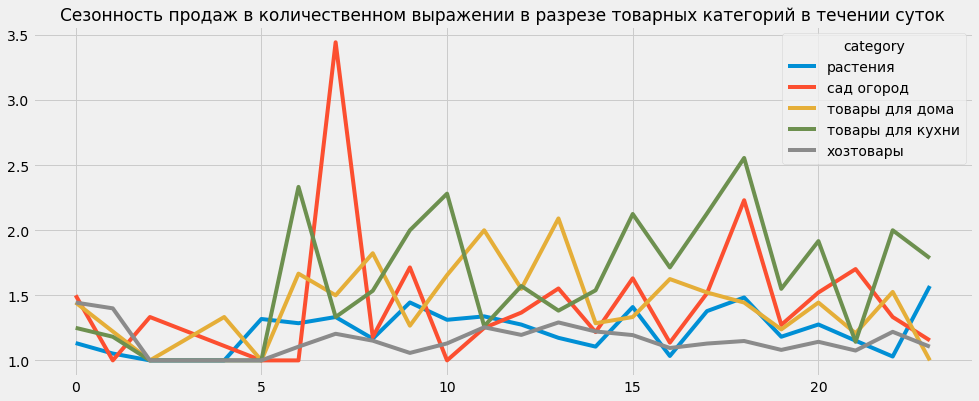

In [63]:
seasons(df, 'category', 'quantity', 'в количественном выражении в разрезе товарных категорий')

__Сезонность в товарных группах по месяцам:__  

>- Все растения декоративные и огородные: - пик продаж апрель и май. Это понятно, потому что сезон. В июле - августе сильный спад и до следующего сезона
>- Товары для кухни: - пик в ноябре. Начало холодов. Люди начинают заедать хандру плодами лета
>- Товары для дома: - относительно ровно в течении года
>- Хозтовары: - в спросе ровно в течении года с небольшим ростом в ноябре (начало зимы) и падением в январе (выходные)

__Сезонность в товарных группах по дням недели:__  

>- Растения декоративные: - спрос относительно ровный
>- Растения огородные: - спрос подскакивает к пятнице, в субботу заметный спад (все на даче)
>- Товары для кухни: - подъем в воскресенье
>- Товары для дома: - относительно ровно
>- Хозтовары: - относительно ровно

__Сезонность в товарных группах в течении суток:__  

>- Во всех группах кроме огорода: - с нуля до 5 утра естественная тишина. Далее в течении суток ровный шум, без особых всплесков. Разве что чуть активней ближе к 7 вечера.
>- Растения огородные: - спрос подскакивает в 7 утра 

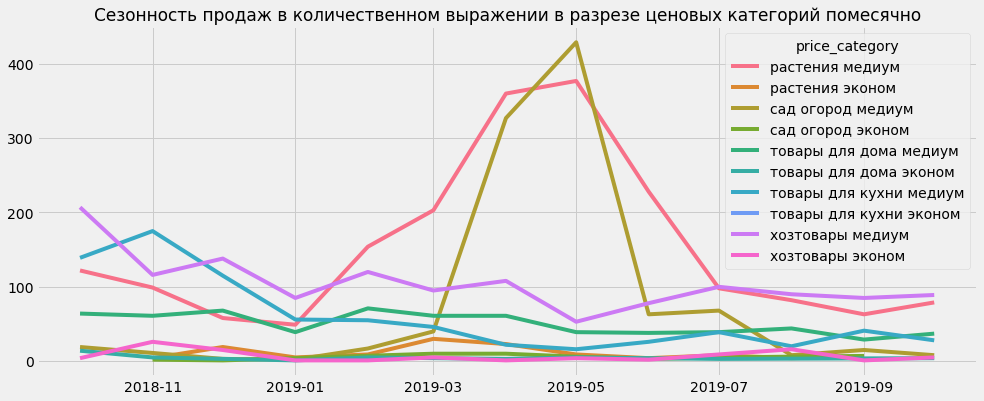

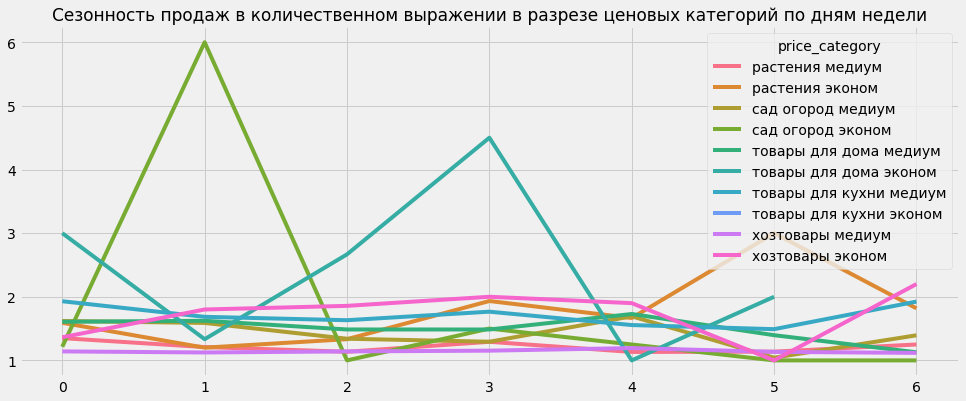

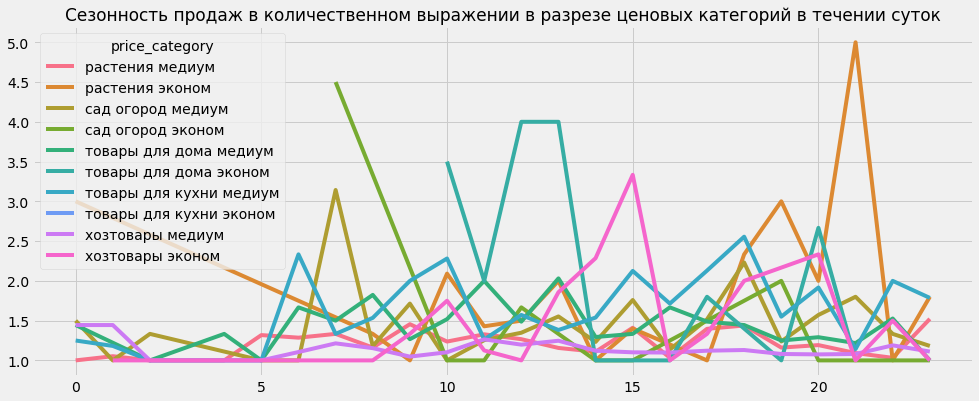

In [64]:
seasons(df, 'price_category', 'quantity', 'в количественном выражении в разрезе ценовых категорий')

__Сезонность в ценовых группах по месяцам:__  

>- Эконом: - в течении всего года ровно
>- Медиум: - пик в в марте - апреле. Если вспомним что в категории медиум в основном растения, то связь очевидна

__Сезонность в ценовых группах по дням недели:__  

>- Медиум: - берут ровно без всплесков
>- Эконом (сад и товары для дома): - заметные всплески по вторникам и четвергам

__Сезонность в ценовых группах в течении суток:__  

>- Медиум и эконом: - спрос скорее похож на шум

 #### 3.7. Разделение ассортимента на основной и дополнительный
[к оглавлению](#step_0)
<a class="anchor" id="step_3.7"></a>

Все товары предлагается разделить на основной и дополнительный по прниципу доли в выручке. Все товары, выручка которых больше 25 пресентиля относим основному ассортименту. Все что ниже - соответсвенно к дополнительному

In [65]:
assortiment = df.groupby('product').agg({'revenue':'sum'}).reset_index()
stat = assortiment.describe(percentiles=[0.25]).T
limit_25 = stat['25%']
assortiment['basic'] = assortiment['revenue'].apply(lambda x: x > limit_25)
assortiment = assortiment.merge(df, how='left', on='product')[['product', 'category', 'basic']].copy()
assortiment.sample(10)

,product,category,basic
2499,пуансеттия в горшке d12 см белая с красным,растения,False
1548,пеларгония зональная диам. 12 см белая махровая,растения,True
3175,спатифиллум d-7 см,растения,True
4278,циперус зумула d-12 см h-25 см,растения,True
1091,лопатка attribute bamboo agb110,хозтовары,False
3749,сушилка для белья потолочно-настенная gimi lif...,хозтовары,True
2207,"петля рояльная цинк 960 мм, 1103055",хозтовары,False
810,коврик интерьерный для кухни la bruschetta из ...,товары для дома,True
3415,сумка-тележка хозяйственная gimi ideal серая (...,хозтовары,True
1850,пеларгония зональная махровая микс d-12 см,растения,True


При покупке клиентом товара, применяя эту таблицу клиенту так же можно предлагать товары из дополнительного ассортимента своей или смежной категории.

## 4. Проверка статистических гипотез
[к оглавлению](#step_0)
<a class="anchor" id="step_4"></a>

Для определения каким тестом будем проверять гипотезы сперва проверим выборки на __нормальность тестом Шапиро-Вилка__

Выдвинем гипотезы:
___
>- __H0__ Выборки распределены нормально применяем параметрический тест Стьюдента
>- __H1__ Выборки распределены не нормально применяем непараметрический тест Манна - Уитни

In [66]:
orders = df.groupby(['order_id', 'price_category']).\
agg({'revenue':'sum','quantity':'sum'}).\
reset_index().sort_values(by='price_category').reset_index(drop=True)
orders.head()

,order_id,price_category,revenue,quantity
0,12624,растения медиум,375.00,2
1,72918,растения медиум,524.00,1
2,71894,растения медиум,74.00,1
3,70916,растения медиум,74.00,1
4,70909,растения медиум,74.00,1


In [67]:
alpha = 0.05
for i in orders['price_category'].unique():
    try:
        results = st.shapiro(orders.query('price_category == @i')['revenue'])
        p_value = results[1]
        print(f'p-значение для категории {gbs}{i} {p_value:.5%}{gbe}')
        if p_value < alpha:
            print('\tОтвергаем нулевую гипотезу: распределение не нормально')
        else:
            print('\tНе получилось отвергнуть нулевую гипотезу, распределение нормально') 
    except:
        pass

p-значение для категории растения медиум 0.00000%
	Отвергаем нулевую гипотезу: распределение не нормально
p-значение для категории растения эконом 0.00014%
	Отвергаем нулевую гипотезу: распределение не нормально
p-значение для категории сад огород медиум 0.00000%
	Отвергаем нулевую гипотезу: распределение не нормально
p-значение для категории сад огород эконом 5.14617%
	Не получилось отвергнуть нулевую гипотезу, распределение нормально
p-значение для категории товары для дома медиум 0.00000%
	Отвергаем нулевую гипотезу: распределение не нормально
p-значение для категории товары для дома эконом 0.46366%
	Отвергаем нулевую гипотезу: распределение не нормально
p-значение для категории товары для кухни медиум 0.00000%
	Отвергаем нулевую гипотезу: распределение не нормально
p-значение для категории хозтовары медиум 0.00000%
	Отвергаем нулевую гипотезу: распределение не нормально
p-значение для категории хозтовары эконом 0.02115%
	Отвергаем нулевую гипотезу: распределение не нормально


Иначе быть не могло. В продажах нормальное распределение - редкость. Призовем на помощь Манна и Уитни. Напишем функцию, которая будет выводить результаты попарных сравнений заданных комбинаций выборок

In [68]:
'''
ФУНКЦИЯ ДЛЯ ВЫВОДА РЕЗУЛЬТАТОВ ПРОВЕРКИ СТАТИСТИЧЕСКИХ ГИПОТЕЗ
На вход подаем:
1. Сырой датафрейм
2. Название столбца по которому группируем
3. Название столбца - измерения на выбор (количество-цена-сумма)
4. Внктри прербираем сочетания без повторений получаем соответсвенные вектора, 
5. Определяем р уровень отностиельное отклонение и комментарий
6. Создаем из словаря отчет и выводим
'''
def hypothesis_tester(df, col_base, col_test):
    alpha = 0.05
    work_df = df.groupby(['order_id', col_base]).agg({'revenue':'sum','quantity':'sum'}).\
    reset_index().sort_values(by=col_base).reset_index(drop=True)
    pairs_of_categoryes = list(combinations(df[col_base].unique(), 2))
    hypo_check = {}
    for i in pairs_of_categoryes:
        first_group_name = i[0]
        first_array = work_df[work_df[col_base] == first_group_name][col_test]
        second_group_name = i[1]
        second_array = work_df[work_df[col_base] == second_group_name][col_test]
        mw_stat = st.mannwhitneyu(first_array, second_array)
        rc = first_array.mean() / second_array.mean() - 1
        if mw_stat.pvalue < alpha:
            anot = 'отклоняем'
        else:
            anot = 'принимаем'
        hypo_check[i] = [mw_stat.pvalue, anot, rc]
    df_result = pd.DataFrame(hypo_check).T.reset_index()
    df_result.columns = ['first_group', 'second_group', 'p-val', 'sulution', f'rc_{col_test}']
    df_result.sort_values(by='p-val', ascending=False)
    return df_result


### Гипотеза 1:
[к оглавлению](#step_0)
<a class="anchor" id="step_4.1"></a>
___
>- __H0__ Количество товаров в заказах всех категорий не отличаются друг от друга. Т.е ключевым фактором в выручке магазина является только цена
>- __H1__ Количество товаров в заказах всех категорий отличаются друг от друга. Т.е ключевым фактором в выручке магазина является не только цена но и количество

In [69]:
display(hypothesis_tester(df, 'price_category', 'quantity'))

,first_group,second_group,p-val,sulution,rc_quantity
0,растения медиум,хозтовары медиум,0.00,отклоняем,1.72
1,растения медиум,хозтовары эконом,0.08,принимаем,0.69
2,растения медиум,товары для дома медиум,0.00,отклоняем,1.03
3,растения медиум,сад огород медиум,0.00,отклоняем,-0.57
4,растения медиум,товары для кухни медиум,0.00,отклоняем,0.43
5,растения медиум,товары для кухни эконом,0.40,принимаем,0.65
6,растения медиум,товары для дома эконом,0.33,принимаем,0.16
7,растения медиум,растения эконом,0.48,принимаем,0.15
8,растения медиум,сад огород эконом,0.13,принимаем,0.05
9,хозтовары медиум,хозтовары эконом,0.00,отклоняем,-0.38


Выясняется что в ценовой группе __медиум__ количество в заказах всех товарных групп попарно различается. 
В __эконом__ наоборот практически во всех группах количество товаров в заказах одинаково. В __премиуме__ не все однозначно. В заказах категорий __товары для кухни и растения__ ,__хозтовары и товары для дома__ скорее всего равны

### Гипотеза 2:
[к оглавлению](#step_0)
<a class="anchor" id="step_4.2"></a>
___
>- __H0__ Средние суммы заказов всех категорий не отличаются друг от друга. Т.е ключевым фактором в выручке магазина является количество заказов 
>- __H1__ Средние суммы заказов всех категорий отличаются друг от друга. Т.е ключевым фактором в выручке магазина является не только количество заказов

Освежим в памяти график кумулятивного среднего заказа по сумме и выведем отчет о проверке гипотез

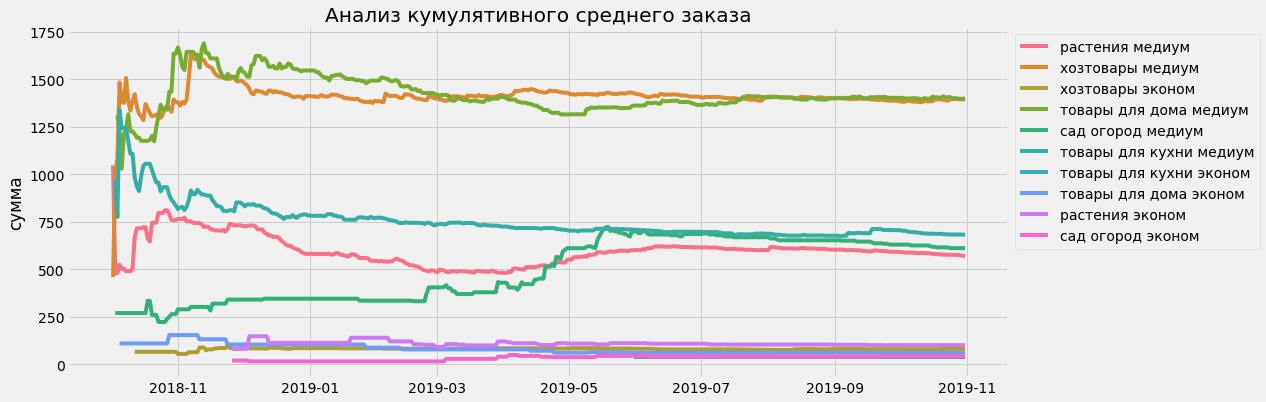

,first_group,second_group,p-val,sulution,rc_revenue
0,растения медиум,хозтовары медиум,0.00,отклоняем,-0.59
1,растения медиум,хозтовары эконом,0.00,отклоняем,5.97
2,растения медиум,товары для дома медиум,0.00,отклоняем,-0.59
3,растения медиум,сад огород медиум,0.19,принимаем,-0.07
4,растения медиум,товары для кухни медиум,0.02,отклоняем,-0.17
5,растения медиум,товары для кухни эконом,0.04,отклоняем,13.95
6,растения медиум,товары для дома эконом,0.00,отклоняем,8.04
7,растения медиум,растения эконом,0.00,отклоняем,4.62
8,растения медиум,сад огород эконом,0.00,отклоняем,12.27
9,хозтовары медиум,хозтовары эконом,0.00,отклоняем,16.07


In [70]:
cumulative_plot(
    cumulative(df, 'price_category', 'revenue')\
    / cumulative(df, 'price_category', 'order_id', 'nunique'), 'кумулятивного среднего заказа', 'сумма')

display(hypothesis_tester(df, 'price_category', 'revenue'))

На графике видно что средние чеки __хозтоваров__ и __товаров для дома__ очень приближены друг к другу. Так же особнячком расположились __кухня растения и сад огород__ Проверка гипотез подтверждает это равенство, кроме __растений и кухни__ Если присмотреться, эти две линии более удалены.

Вернемся к выбросам, которые были обнаружены ранее. Это выбросы в заказах с большим количеством позиций и в клиетах сделавших большое количество заказов. Освежим в памяти о чем речь и создадим новый очищенный датафрейм. Проверим такие же гипотезы на очищенных данных.
<a class="anchor" id="step_11"></a>

In [71]:
q=95

In [72]:
order_outler_list = outlerz(df, 'order_id', 'quantity', 'sum', q)[2]
customer_outler_list = outlerz(df, 'customer_id', 'quantity', 'nunique', q)[2]
customer_outler_list_ = outlerz(df, 'customer_id', 'order_id', 'nunique', q)[2]
print('Список выбросных заказов:', *order_outler_list.to_list(), f'{gbs} Всего {len(order_outler_list)}{gbe}')
print()
print('Список выбросных клиентов:',*customer_outler_list.to_list(), f'{gbs} Всего {len(customer_outler_list)}{gbe}')
print()
print('Список выбросных клиентов:',*customer_outler_list_.to_list(), f'{gbs} Всего {len(customer_outler_list_)}{gbe}')

Список выбросных заказов: 14486 14500 14512 14514 14522 14534 14535 14547 14548 14554 14555 14557 14559 14572 14580 14590 14595 14596 14597 14608 14611 14612 14614 14615 14619 14624 14631 14641 14649 14652 14653 14663 14668 14671 14686 14687 14688 14693 14694 14698 14700 14701 14705 14706 14715 14729 14734 14735 14740 14741 14742 14744 14747 14750 14753 14754 14756 14758 14763 14764 14765 14769 14770 14771 14778 14783 14784 14786 14789 14791 14795 14798 14805 14809 14822 14823 14824 14825 14826 14827 14830 14831 14833 14835 14838 14841 14842 14848 14863 14873 14878 14882 14891 14892 14893 14897 14917 14932 14937 14941 68494 68523 68544 68610 68621 68643 68721 68760 68773 68822 68844 68858 68860 68941 69028 69050 69072 69090 69100 69101 69156 69175 69176  Всего 123

Список выбросных клиентов: 0184f535-b60a-4914-a982-231e3f615206 17ca17e1-9544-48ea-a053-368480d66e6f 1809d8b0-c702-450d-a73c-76fc90386411 2a0acc09-e343-4f92-b5c0-f598ef2b07d4 2f2bcc7f-bb73-4266-b419-4e325af1d26d 470bf3f8-7b9

In [73]:
df_clean = df.query(
    'order_id not in @order_outler_list\
    and customer_id not in @customer_outler_list \
    and customer_id not in @customer_outler_list_')

### Гипотеза 1*:
(Проверяем на очищенных данных)
___
>- __H0__ Количество товаров в заказах всех категорий не отличаются друг от друга. Т.е ключевым фактором в выручке магазина является только цена
>- __H1__ Количество товаров в заказах всех категорий отличаются друг от друга. Т.е ключевым фактором в выручке магазина является не только цена но и количество

In [74]:
display(hypothesis_tester(df_clean, 'price_category', 'quantity'))

,first_group,second_group,p-val,sulution,rc_quantity
0,растения медиум,хозтовары медиум,0.00,отклоняем,0.71
1,растения медиум,хозтовары эконом,0.33,принимаем,0.14
2,растения медиум,товары для дома медиум,0.00,отклоняем,0.33
3,растения медиум,сад огород медиум,0.00,отклоняем,-0.29
4,растения медиум,товары для кухни медиум,0.03,отклоняем,0.11
5,растения медиум,товары для кухни эконом,0.27,принимаем,0.02
6,растения медиум,товары для дома эконом,0.17,принимаем,-0.10
7,растения медиум,растения эконом,0.49,принимаем,0.05
8,растения медиум,сад огород эконом,0.25,принимаем,-0.10
9,хозтовары медиум,хозтовары эконом,0.00,отклоняем,-0.34


После очистки от выбросов ситуация не особо изменилась. В ценовой категории __медиум__ среднее количество товаров в заказе разное. В __экономе__ наоборот одинаковое

### Гипотеза 2*:
(проверяем на очищенных данных)
___
>- __H0__ Средние суммы заказов всех категорий не отличаются друг от друга. Т.е ключевым фактором в выручке магазина является количество заказов 
>- __H1__ Средние суммы заказов всех категорий отличаются друг от друга. Т.е ключевым фактором в выручке магазина является не только количество заказов

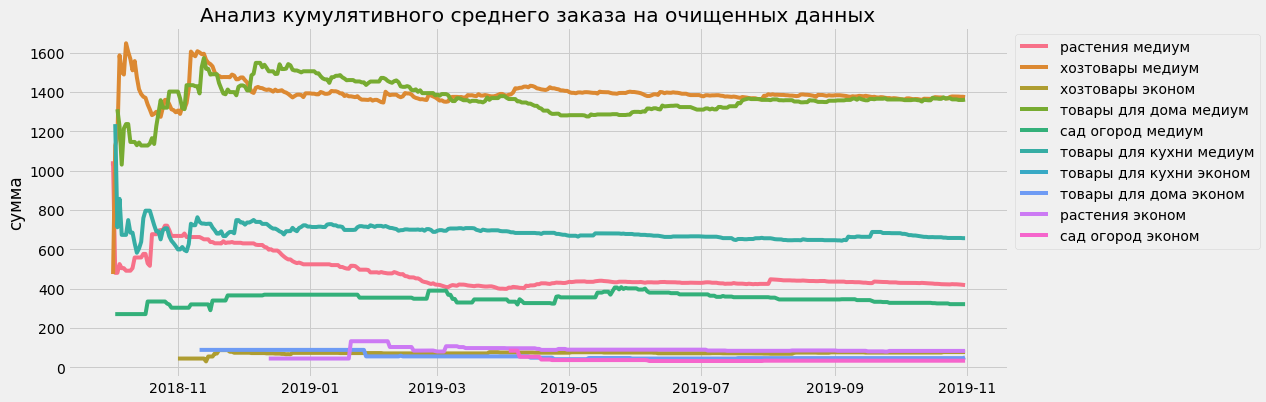

,first_group,second_group,p-val,sulution,rc_revenue
0,растения медиум,хозтовары медиум,0.00,отклоняем,-0.70
1,растения медиум,хозтовары эконом,0.00,отклоняем,4.41
2,растения медиум,товары для дома медиум,0.00,отклоняем,-0.69
3,растения медиум,сад огород медиум,0.06,принимаем,0.30
4,растения медиум,товары для кухни медиум,0.00,отклоняем,-0.37
5,растения медиум,товары для кухни эконом,0.04,отклоняем,9.95
6,растения медиум,товары для дома эконом,0.00,отклоняем,7.32
7,растения медиум,растения эконом,0.00,отклоняем,4.03
8,растения медиум,сад огород эконом,0.00,отклоняем,11.61
9,хозтовары медиум,хозтовары эконом,0.00,отклоняем,16.85


In [75]:
cumulative_plot(
    cumulative(df_clean, 'price_category', 'revenue')\
    / cumulative(df_clean, 'price_category', 'order_id', 'nunique'), 'кумулятивного среднего заказа на очищенных данных', 'сумма')
display(hypothesis_tester(df_clean, 'price_category', 'revenue'))

Одинаковыми оказались преимущественно стоимости заказов в подкатегориях __эконом__  а так же __хозтоваров__ и __товаров для дома__ таким образом основным параметром в увеличении выручки в этих категориях является увеличение количества заказов

## 5. Выводы и рекомендации
[к оглавлению](#step_0)
<a class="anchor" id="step_5"></a>

__В ходе анализа было выявлено следующее:__
____

>- Основную выручку магазину создают __хозтовары__ за счет наибольшего количества заказов около 1200 шт и высокой стоимости заказа - 1400 р.
>- При такой же стоимости 1400 р. но при количестве 400 шт категория __товары для дома__ занимает второе место
>- При большЕм количестве заказов - около 600 и стоимости заказа 600 р. __растения__ занимают третье место
>- Предпоследнее место занимают __товары для кухни__ не самая высокая стоимость заказа и не самые высокие количества.
>- Последнее место за __огородными растениями__ самые низкие цены в заказе плюс самые низкие продажи, - на продажи этой категории сильно влияет фактор сезонности
____

__Рекомендации:__
>- Наибольшее внимание уделять поддержанию запасов __хозтоваров.__ как самой продаваемой группе товаров с самой высокой стоимостью заказа, генерирующую наибольшую выручку.
>- Особое внимание уделять оптовым покупателям. В течении 13 месяцев всего 241 чел принес 32% выручки. Возможно вывести таких клиентов в отдельное направление.
>- Стимулировать продажи __товаров для дома__ как такую же высокодоходную категорию как и __хозтовары__, но отстающую в количестве заказов.
>- Учесть сезонность продаж огородных растений при планировании запасов.
>- Учесть суточную активность в продажах огородных растений т.е. предлагать при продаже товаров смежных товарных групп примерно в 7-8 утра.
>- В ценовой категории __медиум__ учесть факт не одинаковости заказов по количеству во всех товарных группах т.е. при покупке товаров определенной товарной категории рекомендовать товары соответствующей __эконом__ серии.

__Баг репорт:__
>- Учесть факт задвоения заказов. 
>- Разобрать причины с дата-инженерами.